<a href="https://colab.research.google.com/github/pachterlab/GVFP_2021/blob/dev/figure_4_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identification of CIR- and $\Gamma$-OU-like genes

In the current notebook, we attempt to find genes that consistently with the CIR and $\Gamma$-OU models of stochastic time-dependent transcription, as well as genes that cannot be confidently assigned to one of the two models.

## Colab or non-local prerequisites

In [ ]:
!git clone https://github.com/pachterlab/monod.git

In [1]:
import sys
sys.path.insert(0, './monod/src/')

Necessary only in Colab.

In [ ]:
!pip install matplotlib --upgrade

In [ ]:
!git clone --branch dev https://github.com/pachterlab/GVFP_2021.git

Cloning into 'GVFP_2021'...
remote: Enumerating objects: 1912, done.
remote: Counting objects: 100% (558/558), done.
remote: Compressing objects: 100% (321/321), done.
remote: Total 1912 (delta 247), reused 548 (delta 237), pack-reused 1354
Receiving objects: 100% (1912/1912), 846.36 MiB | 34.63 MiB/s, done.
Resolving deltas: 100% (811/811), done.
Checking out files: 100% (613/613), done.


In [ ]:
!mv GVFP_2021/* .

In [ ]:
!rm -r GVFP_2021

In [ ]:
%%capture
!pip install loompy anndata numdifftools

## Predictive filtering: prerequisites

First, we do a round of preliminary filtering using five moderate- to high-abundance glutamatergic cell subtypes from one mouse (B08), released by the Allen Brain Institute. This requires the *Monod* framework.

In [1]:
import time
t1 = time.time()

Define the dataset metadata and disk locations.

In [2]:
subcluster_loom_dir = './home/ggorin/count_data/loom_allen_kb/'
loom_directory = './home/ggorin/count_data/loom_allen_kb/'

In [3]:
transcriptome_filepath = './fits/gg_200524_mouse_genome_polyA_cum_1'

In [23]:
subcluster_dataset = 'B08'
subcluster_names = ['L2/3 IT','L5 IT','L6 IT','L5/6 NP', 'L6 CT', 'L6b']
subcluster_names = [x.replace(' ','').replace('/','') for x in subcluster_names]
subcluster_dataset_names = ['allen_{}_{}'.format(subcluster_dataset,y)  for y in subcluster_names] 
n_subcluster_datasets = len(subcluster_dataset_names)
subcluster_loom_filepaths = [subcluster_loom_dir+'allen_'+subcluster_dataset+'_raw.loom']*n_subcluster_datasets

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]


In [24]:
subcluster_dataset_names

['allen_B08_L23IT',
 'allen_B08_L5IT',
 'allen_B08_L6IT',
 'allen_B08_L56NP',
 'allen_B08_L6CT',
 'allen_B08_L6b']

Define out-of-sample datasets.

In [25]:
sample_names = ['C01','B08','H12','F08']
dataset_names = ['allen_'+y+'_glu'  for y in sample_names] 
sample_looms = [loom_directory+'allen_'+x+'_raw.loom' for x in sample_names] 
n_datasets = len(dataset_names)

In [26]:
sample_looms

['./home/ggorin/count_data/loom_allen_kb/allen_C01_raw.loom',
 './home/ggorin/count_data/loom_allen_kb/allen_B08_raw.loom',
 './home/ggorin/count_data/loom_allen_kb/allen_H12_raw.loom',
 './home/ggorin/count_data/loom_allen_kb/allen_F08_raw.loom']

Define models to analyze.

In [27]:
models = ('Bursty','CIR','Extrinsic')
n_models = len(models)
colors = ('red',(0., 174/255, 239/255),'slateblue')
gou_color=colors[0]
cir_color=colors[1]
ext_color=colors[2]

This is the local installation of *Monod*, and should not be used on other machines.

In [28]:
import sys
sys.path.insert(0, '/home/ggorin/projects/monod/src/')

In [29]:
import monod
from monod.preprocess import *
from monod.extract_data import extract_data
import monod.cme_toolbox as cme_toolbox
from monod.cme_toolbox import CMEModel
import monod.inference as inference
from monod.inference import InferenceParameters, GradientInference
import monod.analysis as analysis
from monod.analysis import *

## Helper functions

These helper functions evaluate and fit the $\Gamma$-OU and CIR models.

In [30]:
def par_fun_fullfit(fitinput):
    U,S,n_restarts,maxiter = fitinput
    reduced_guess=None
    limit=None
    pars_sde_gou = convert_pars(get_MLE('GOU',U,S,reduced_guess,disp=False,limit=limit,n_restarts=n_restarts,maxiter=maxiter))
    pars_sde_cir = convert_pars(get_MLE('CIR',U,S,reduced_guess,disp=False,limit=limit,n_restarts=n_restarts,maxiter=maxiter))
    lik_ratio, logL_gou, logL_cir = get_lik_ratio(pars_sde_gou,pars_sde_cir,U,S)
    return lik_ratio,pars_sde_gou,pars_sde_cir,logL_gou, logL_cir


def get_MoM(U,S):
    raw_guess = np.zeros(4)
    Um = U.mean()
    Uv = U.var()
    Sm = S.mean()
    Sv = S.var()

    beta = 1/Um #assuming <k>=1
    gamma = 1/Sm
    kappa = beta / ( (Sv - Sm)/(Uv - Um) * Um * (beta + gamma) / (Sm*beta) - 1) - gamma
    theta = (kappa+beta)/Um * (Uv - Um)
    
    a = kappa/theta
    
    raw_guess = np.asarray([beta,gamma,kappa,theta])/a
    
    return raw_guess

def get_MLE(model,U,S,reduced_guess=None,disp=True,limit='fast',n_restarts = 4,maxiter=10):
    data = np.unique(np.vstack((U,S)).astype(int),\
                     axis=1,return_counts=True)
    
    
    phys_lb = np.asarray([-2]*4)+np.random.randn(4)*0.02
    phys_ub = np.asarray([2]*4)+np.random.randn(4)*0.02
    phys_lb_raw = 10**phys_lb
    phys_ub_raw = 10**phys_ub
    
    initial_guess = np.zeros(4)
    if reduced_guess is not None:
        raw_guess = 10**reduced_guess
        if limit=='fast':
            initial_guess[0] = raw_guess[1] #beta
            initial_guess[1] = raw_guess[2] #gamma
            initial_guess[2] = 5.9 #kappa -- must be pretty fast
            initial_guess[3] = raw_guess[0]*initial_guess[2] #theta
        elif limit=='slow':
            initial_guess[2] = 1/raw_guess[0] #alpha=a/kappa, a set to 1
            initial_guess[3] = 4 #theta: arbitary
            initial_guess[0] = raw_guess[1]*initial_guess[3] #beta
            initial_guess[1] = raw_guess[2]*initial_guess[3] #gamma
    else:
        raw_guess = get_MoM(U,S)
        initial_guess = np.clip(raw_guess,phys_lb_raw,phys_ub_raw)
    log_initial_guess = np.log10(initial_guess)
    
    if model=='CIR':
        pssfun = get_CIR_2sp
    if model=='GOU':
        pssfun = get_GOU_2sp
        
    err = np.inf
    err_thr = 0.99
    if n_restarts>0:
        for restart in range(n_restarts):
            if restart>0:
                log_initial_guess = np.random.rand(4) * (phys_ub-phys_lb) + phys_lb
            grad_bnd=scipy.optimize.Bounds(phys_lb,phys_ub)
            res_arr = scipy.optimize.minimize(lambda x: get_kld(x,pssfun,data),
                                x0=log_initial_guess, \
                                bounds=grad_bnd,\
                                options={'maxiter':maxiter,'disp':disp})
            if res_arr.fun<err*err_thr:
                x=res_arr.x
                err=res_arr.fun
        return x
    else:
        return log_initial_guess
    
    
def convert_pars(pars): #go from log10 4 parameters to raw 5 parameters
    raw_pars = 10**pars
    pars_sde = np.zeros(5)
    pars_sde[0] = raw_pars[0] #beta
    pars_sde[1] = raw_pars[1] #gamma
    pars_sde[2] = 1
    pars_sde[3] = raw_pars[2] #kappa
    pars_sde[4] = raw_pars[3] #theta
    return pars_sde

def get_lik_ratio(pars_gou,pars_cir,U,S,EPS=1e-15):
    data = np.unique(np.vstack((U,S)).astype(int),\
                     axis=1,return_counts=True)
    unique_values, counts = data
    coords = tuple([tuple(x) for x in unique_values.T])
    mx = unique_values.max(1)+10
    pss_gou = get_GOU_2sp(np.copy(mx),pars_gou)
    pss_cir = get_CIR_2sp(np.copy(mx),pars_cir)
    
    pss_gou[pss_gou<EPS] = EPS
    pss_gou = [pss_gou[x] for x in coords]
    pss_cir[pss_cir<EPS] = EPS
    pss_cir = [pss_cir[x] for x in coords]
    logL_gou = (counts * np.log(pss_gou)).sum()
    logL_cir = (counts * np.log(pss_cir)).sum()
    lik_ratio = logL_cir - logL_gou
    return lik_ratio, logL_gou, logL_cir
    
    

def get_kld(pars,pssfun,data,EPS=1e-15):
    unique_values, counts = data
    mx = unique_values.max(1)+10
    proposal_probabilities = pssfun(np.copy(mx),convert_pars(pars))
    proposal_probabilities[proposal_probabilities<EPS] = EPS
    coords = tuple([tuple(x) for x in unique_values.T])
    proposal_probabilities = [proposal_probabilities[x] for x in coords]
    kld = counts * np.log(counts / proposal_probabilities)
    return np.sum(kld)


from numpy.fft import irfftn
x_gauss,w_gauss = scipy.special.roots_legendre(60, mu=False)

def get_gf_GOU_2sp_ODE(g0, g1, params):
    beta_0, beta_1, a, kappa, theta = params     # get parameters
    
    c0 = (g0) + (beta_0/(beta_1 - beta_0))*(g1)       #  relevant linear combinations of g_i
    c1 = - (beta_0/(beta_1 - beta_0))*(g1)   
    
    min_fudge, max_fudge = 1, 10                                     # Determine integration time scale / length
    dt = np.min([1/kappa, 1/theta, 1/beta_0, 1/beta_1])*min_fudge
    t_max = np.max([1/kappa, 1/theta, 1/beta_0, 1/beta_1])*max_fudge
    num_tsteps = int(np.ceil(t_max/dt))
    
#     t_array = np.linspace(0, t_max, num_tsteps+1)
#     t_array = t_array.reshape((1, num_tsteps + 1))
    t_array = (t_max*(x_gauss+1)/2)[None,:]
    
    q = np.zeros((g0.shape[0], num_tsteps + 1), dtype=np.complex64)    # initialize array to store ODE
    c0 = c0.reshape((c0.shape[0],1))
    c1 = c1.reshape((c1.shape[0],1))

    q0 = theta*c0*(np.exp(-beta_0*t_array) - np.exp(-kappa*t_array))/(kappa - beta_0) 
    q1 = theta*c1*(np.exp(-beta_1*t_array) - np.exp(-kappa*t_array))/(kappa - beta_1)
    q = q0 + q1
    

    integrand = q/(1-q)
    
#     print(integrand.shape)
#     print(w_gauss.shape)
    integral=np.matmul(integrand,w_gauss[:,None]).sum(1)/2*t_max
#     integral = np.trapz(integrand, dx=dt, axis=1)     # integrate ODE solution
    gf = np.exp( a*integral)               # get generating function
    return gf


# Get Pss for 2 species GOU model via ODE method
def get_GOU_2sp(mx, params):
    # Get generating function argument
    u = []
    half = np.copy(mx[:])
    half[-1] = mx[-1]//2 + 1
    for i in range(len(mx)):
        l = np.arange(half[i])
        u_ = np.exp(-2j*np.pi*l/mx[i])-1
        u.append(u_)
    g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
    for i in range(len(mx)):
        g[i] = g[i].flatten()
    
    # Get generating function
    gf = get_gf_GOU_2sp_ODE(g[0], g[1], params)                    
    gf = gf.reshape(tuple(half))
    
    Pss = irfftn(gf, s=mx)                        # Get Pss by inverse fast Fourier transform
    Pss = np.abs(Pss)/np.sum(np.abs(Pss))           # Normalize
    return Pss


# ODE for 2 species CIR model
def f_2sp(q, t, c0, c1, params):
    beta_0, beta_1, a, kappa, theta = params
    result = - kappa*q + theta*q*q + kappa*( c0*np.exp(-beta_0*t) + c1*np.exp(-beta_1*t)  ) 
    return result


# Vectorized RK4 implementation for 2 species CIR model
def RK4_2sp(q, f, t, c0, c1, step_size, param):
    j1 = f(q, t, c0, c1, param)
    j2 = f(q + (step_size/2)*j1, t + (step_size/2), c0, c1, param)   
    j3 = f(q + (step_size/2)*j2, t + (step_size/2), c0, c1, param)   
    j4 = f(q + (step_size)*j3, t + (step_size), c0, c1, param)  
    
    q_new = q + (step_size/6)*(j1 + 2*j2 + 2*j3 + j4)
    return q_new


# Get 2 species CIR generating function using ODE method
def get_gf_CIR_2sp(g0, g1, params):
#     print('in pgf routine')
    beta_0, beta_1, a, kappa, theta = params     # get parameters
    
    c0 = (g0) + (beta_0/(beta_1 - beta_0))*(g1)       #  relevant linear combinations of g_i
    c1 = - (beta_0/(beta_1 - beta_0))*(g1)   

    t_max = (1/np.asarray(params)).max()*5   
    c0 = c0[:,None]
    c1 = c1[:,None]
    t_eval = t_max*(x_gauss+1)/2
    def intfun_(t,y):
        return f_2sp(y, t, c0, c1, params)
    rk = scipy.integrate.solve_ivp(fun=intfun_,t_span=[0,t_max],y0=np.zeros((g0.shape[0]), dtype=np.complex64),t_eval = t_eval,
                              vectorized=True)
    try:
        integral = np.matmul(rk.y,w_gauss[:,None]).sum(1)/2*t_max
    except:
        print('falling back on jjv solution')
        min_fudge, max_fudge = 0.5, 10                                     # Determine integration time scale / length
        dt = np.min([1/kappa, 1/theta, 1/beta_0, 1/beta_1])*min_fudge
        num_tsteps = int(np.ceil(t_max/dt))
        q = np.zeros((g0.shape[0], num_tsteps + 1), dtype=np.complex64)    # initialize array to store ODE

        # Solve ODE using RK4 method 
        for i in range(0, num_tsteps):
            t = i*dt
            q[:,i+1] = RK4_2sp(q[:,i], f_2sp, t, c0[:,0], c1[:,0], dt, params)

        integral = np.trapz(q, dx=dt, axis=1)     # integrate ODE solution
        if (~np.isfinite(integral)).any():
            print('Procedure failed.')
            print(params)
            print(rk.y.shape)
            print(w_gauss[:,None].shape)
            print(t_eval.shape)
            print(x_gauss.shape)
            print(t_max)
            
    gf = np.exp((a*theta/kappa)*integral)               # get generating function
    return gf


# Get Pss for 2 species CIR model via ODE method
def get_CIR_2sp(mx, params):
    # Get generating function argument
    u = []
    half = np.copy(mx[:])
    half[-1] = mx[-1]//2 + 1
    for i in range(len(mx)):
        l = np.arange(half[i])
        u_ = np.exp(-2j*np.pi*l/mx[i])-1
        u.append(u_)
    g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
    for i in range(len(mx)):
        g[i] = g[i].flatten()
    
    # Get generating function
    gf = get_gf_CIR_2sp(g[0], g[1], params)                    
    gf = gf.reshape(tuple(half))
                              
    Pss = irfftn(gf, s=mx)                        # Get Pss by inverse fast Fourier transform
    Pss = np.abs(Pss)/np.sum(np.abs(Pss))           # Normalize
    return Pss


## Predictive filtering: preprocessing

Construct a batch by finding 3,000 genes which have at least moderate expression across all datasets. Visualize the set of genes (purple) that meet the expression filtering criteria.

In [ ]:
subcluster_dir_string,subcluster_dataset_strings = construct_batch(subcluster_loom_filepaths, \
                                             transcriptome_filepath, \
                                             subcluster_dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='subtypes',batch_id=1,\
                                             n_genes=3000,viz=False,datestring='nodate',creator='GVFP')

INFO:root:Beginning data preprocessing and filtering.
INFO:root:Dataset: allen_B08_l23it
INFO:root:621 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:5864 genes retained after expression filter.
INFO:root:Dataset: allen_B08_l5it
INFO:root:1702 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:6759 genes retained after expression filter.
INFO:root:Dataset: allen_B08_l6it
INFO:root:471 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:5773 genes retained after expression filter.
INFO:root:Dataset: allen_B08_l56np
INFO:root:191 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:4268 genes retained after expression filter.
INFO:root:Dataset: allen_B08_l6ct
INFO:root:1359 cells detected.
INFO:root:32285 features observed, 32005 match genome anno

## Predictive filtering: inference with *Monod*

Here, we iterate over the subcluster datasets and fit the three models, omitting technical noise.

In [ ]:
def par_fun_monod(x):
    models = ('Bursty','CIR','Extrinsic')
    n_models = len(models)
    fp,tx,dn,ds,dirs,att = x
    result_strings = []
    for j in range(n_models):
        fitmodel = CMEModel(models[j],'None')
        inference_parameters = InferenceParameters([-2.0, -2.0, -2.0],[4.2, 2.5, 3.5],[1,1],[1,1],[1,1],\
                    ds,fitmodel,use_lengths = False,
                    gradient_params = {'max_iterations':10,'init_pattern':'moments','num_restarts':1})
        if j==0:
            search_data = extract_data(fp,tx,dn,
                                ds,dirs,dataset_attr_names=att)
        else:
            search_data = load_search_data(ds+'/raw.sd')
        full_result_string = inference_parameters.fit_all_grid_points(1,search_data)
        result_strings.append(full_result_string)
    return result_strings

In [ ]:
subcluster_loom_filepaths

['./loom/allen_B08_l23it.loom',
 './loom/allen_B08_l5it.loom',
 './loom/allen_B08_l6it.loom',
 './loom/allen_B08_l56np.loom',
 './loom/allen_B08_l6ct.loom']

In [ ]:
try:
    pool = multiprocessing.Pool(processes=5)
    iterable = zip(subcluster_loom_filepaths,[transcriptome_filepath]*n_subcluster_datasets,\
                   subcluster_dataset_names,subcluster_dataset_strings,\
                   [subcluster_dir_string]*n_subcluster_datasets,[attribute_names]*n_subcluster_datasets)
    pool.map(par_fun_monod, iterable)
    pool.close()
    pool.join()
except:
    print('failed!')
    pool.terminate()
    pool.join()

INFO:root:Sequencing model set to None. All sampling parameters set to null.
INFO:root:Sequencing model set to None. All sampling parameters set to null.
INFO:root:Sequencing model set to None. All sampling parameters set to null.
INFO:root:Sequencing model set to None. All sampling parameters set to null.
INFO:root:Sequencing model set to None. All sampling parameters set to null.
INFO:root:Global inference parameters stored to ./fits/GVFP_nodate_022_subtypes_1/allen_B08_l23it/Bursty_None_1x1/parameters.pr.
INFO:root:Global inference parameters stored to ./fits/GVFP_nodate_022_subtypes_1/allen_B08_l6it/Bursty_None_1x1/parameters.pr.
INFO:root:Global inference parameters stored to ./fits/GVFP_nodate_022_subtypes_1/allen_B08_l5it/Bursty_None_1x1/parameters.pr.
INFO:root:Global inference parameters stored to ./fits/GVFP_nodate_022_subtypes_1/allen_B08_l6ct/Bursty_None_1x1/parameters.pr.
INFO:root:Global inference parameters stored to ./fits/GVFP_nodate_022_subtypes_1/allen_B08_l56np/Burs

INFO:root:Runtime: 36.3 seconds.
INFO:root:Non-parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/GVFP_nodate_022_subtypes_1/allen_B08_l6it/CIR_None_1x1/analysis_figures created.
INFO:root:Runtime: 254.2 seconds.
INFO:root:Sequencing model set to None. All sampling parameters set to null.
INFO:root:Directory ./fits/GVFP_nodate_022_subtypes_1/allen_B08_l6it/Extrinsic_None_1x1 created.
INFO:root:Global inference parameters stored to ./fits/GVFP_nodate_022_subtypes_1/allen_B08_l6it/Extrinsic_None_1x1/parameters.pr.
INFO:root:Search data loaded from ./fits/GVFP_nodate_022_subtypes_1/allen_B08_l6it/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:Non-parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/GVFP_nodate_022_subtypes_1/allen_B08_l23it/CIR_None_1x1/analysis_figures created.
INFO:root:Runtime: 276.2 seconds.
INFO:root:Sequencing model set to None. All sam

In [ ]:
subcluster_dir_string

'./fits/GVFP_nodate_022_subtypes_1'

In [ ]:
t2=time.time()
print('Runtime: {:.1f} minutes.'.format((t2-t1)/60))

Runtime: 11.4 minutes.


## Predictive filtering: analysis of *Monod* results and AIC computation

You can restart from here by loading in the result files and regenerating the search data files.

In [10]:
%%capture
subcluster_dir_string = './fits/GVFP_nodate_022_subtypes_1'
subcluster_dataset_strings = [subcluster_dir_string+'/'+x for x in subcluster_dataset_names]
sd_arr = [extract_data(*x) for x in zip(subcluster_loom_filepaths,[transcriptome_filepath]*n_subcluster_datasets,\
                   subcluster_dataset_names,subcluster_dataset_strings,\
                   [subcluster_dir_string]*n_subcluster_datasets,[attribute_names]*n_subcluster_datasets)]


INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_B08_l23it
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/GVFP_nodate_022_subtypes_1/genes.csv.
INFO:root:Search data stored to ./fits/GVFP_nodate_022_subtypes_1/allen_B08_l23it/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_B08_l5it
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/GVFP_nodate_022_subtypes_1/genes.csv.
INFO:root:Search data stored to ./fits/GVFP_nodate_022_subtypes_1/allen_B08_l5it/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_B08_l6it
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/GVFP_nodate_022_subtypes_1/genes.csv.
INFO:root:Search data stored to ./fits/GVFP_nodate_022_subtypes_1/allen_B08_l6it/raw.sd.
INFO:root:Beginning 

In [11]:
subcluster_result_strings = [[subcluster_dir_string+'/'+x+'/'+y+'_None_1x1/grid_scan_results.res' \
                   for x in subcluster_dataset_names] \
                  for y in models]

In [12]:
sr_arr = []
for j in range(n_subcluster_datasets):
    sr_ = []
    for k in range(n_models):
        loaded_res = load_search_results(subcluster_result_strings[k][j])
        loaded_res.find_sampling_optimum()
        sr_.append(loaded_res)
    make_batch_analysis_dir(sr_,subcluster_dir_string)
    sr_arr.append(sr_)

INFO:root:Grid scan results loaded from ./fits/GVFP_nodate_022_subtypes_1/allen_B08_l23it/Bursty_None_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/GVFP_nodate_022_subtypes_1/allen_B08_l23it/CIR_None_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/GVFP_nodate_022_subtypes_1/allen_B08_l23it/Extrinsic_None_1x1/grid_scan_results.res.
INFO:root:Directory ./fits/GVFP_nodate_022_subtypes_1/analysis_figures created.
INFO:root:Grid scan results loaded from ./fits/GVFP_nodate_022_subtypes_1/allen_B08_l5it/Bursty_None_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/GVFP_nodate_022_subtypes_1/allen_B08_l5it/CIR_None_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/GVFP_nodate_022_subtypes_1/allen_B08_l5it/Extrinsic_None_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/GVFP_nodate_022_subtypes_1/allen_B08_l6it/Bursty_None_1x1/grid_scan_results.res.
INFO:root:Grid scan r

In [13]:
[sd.n_cells for sd in sd_arr]

[621, 1702, 471, 191, 1359]

In [14]:
w = []
for j in range(n_subcluster_datasets):
    w_ = get_AIC_weights(sr_arr[j],sd_arr[j])
    w.append(w_)
w = np.asarray(w)

In [15]:
gf_gou = (w[:,0,:]>0.9).all(0)
gf_cir = (w[:,1,:]>0.5).all(0)
gf_ext = (w[:,2,:]>0.8).all(0)
gfs = np.vstack((gf_gou,gf_cir,gf_ext))


In [16]:
w_bary = np.tensordot(w,np.asarray([[0,0],[1,0],[1/2,np.sqrt(3)/2]]).T,axes=([1],[1]))

Change subcluster index here to plot for other datasets.

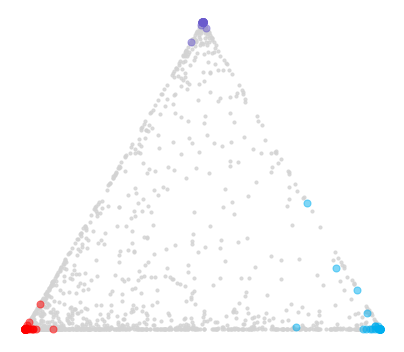

In [17]:
subcluster_index=0
fig1,ax1=plt.subplots(1,1,figsize=(7,7))
ax1.scatter(w_bary[subcluster_index,~gfs.any(0),0],w_bary[subcluster_index,~gfs.any(0),1],10,'lightgray',alpha=0.8)
for k in range(3):
    ax1.scatter(w_bary[subcluster_index,gfs[k],0],w_bary[subcluster_index,gfs[k],1],50,colors[k],alpha=0.5)
ax1.axis('off')
ax1.set_aspect('equal')
plt.savefig('fig/ternary.png',dpi=450)
plt.savefig('fig/ternary.svg')
plt.savefig('fig/ternary.pdf')

In [18]:
gn = sd_arr[0].gene_names

In [19]:
chisq_thr = 5
gene_inds_kept = []
for model_ind in range(n_models):
    n_genes = gfs[model_ind].sum()
    gene_inds = np.where(gfs[model_ind])[0]
    keep = np.zeros((n_genes,n_subcluster_datasets),dtype=bool)
    pval = np.zeros((n_genes,n_subcluster_datasets))
    for gene_count,gene_ind in enumerate(gene_inds):
        for dataset in range(n_subcluster_datasets):
            lm = [sd_arr[dataset].M[gene_ind], sd_arr[dataset].N[gene_ind]]
            pars = sr_arr[dataset][model_ind].phys_optimum[gene_ind]
            expect_freq = sr_arr[dataset][model_ind].model.eval_model_pss(pars,lm) * sd_arr[dataset].n_cells
            
            unique_values,counts = np.unique(np.vstack(\
                       (sd_arr[dataset].U[gene_ind],sd_arr[dataset].S[gene_ind])).astype(int),axis=1,\
                        return_counts=True) #create the dataset of observed counts
            expect_freq = expect_freq[unique_values[0],unique_values[1]]
                #the added bin accounts for all the stuff that's not in the 
                #observed categories
            expect_freq = np.concatenate((expect_freq,[sd_arr[dataset].n_cells-expect_freq.sum()]))
            counts = np.concatenate((counts,[0])) 
            
            filt = (expect_freq>chisq_thr) & (counts>chisq_thr)
            observed = np.concatenate((counts[filt],[counts[~filt].sum()]))
            proposed = np.concatenate((expect_freq[filt],[expect_freq[~filt].sum()])) #this is incredibly severe.
            csq = scipy.stats.mstats.chisquare(observed, proposed, 3) #3 dof because models have 3 parameters...
            pval[gene_count,dataset] = csq.pvalue
            if csq.pvalue>0.01:
                keep[gene_count,dataset] = True
                
    gene_inds_kept.append(gene_inds[keep.all(1)])

In [20]:
n_cells = np.asarray([sd.n_cells for sd in sd_arr])
subtype_weights = n_cells/n_cells.sum()

In [21]:
results = []
for model_ind in range(n_models):
    data = {'meta':models[model_ind],'genes':gn[gene_inds_kept[model_ind]],'aic':w[:,:,gene_inds_kept[model_ind]]}
    n_genes = len(data['genes'])
    pars = np.zeros((n_genes,n_subcluster_datasets,3))
    for gene_count,gene_ind in enumerate(gene_inds_kept[model_ind]):
        for dataset in range(n_subcluster_datasets):
            pars[gene_count,dataset] = sr_arr[dataset][model_ind].phys_optimum[gene_ind]
    data['pars'] = pars
    data['par_initial_guess'] = (pars*subtype_weights[None,:,None]).sum(1)
    results.append(data)


In [22]:
with open(subcluster_dir_string+'/weights_and_genes.pickle','wb') as rfs:
    pickle.dump(results,rfs)

In [23]:
t2=time.time()
print('Runtime: {:.1f} minutes.'.format((t2-t1)/60))

Runtime: 4.2 minutes.


## Out-of-sample analysis

We can restart here.

In [ ]:
n_cores=33

In [ ]:
subcluster_dir_string = './fits/GVFP_nodate_022_subtypes_1'
with open(subcluster_dir_string+'/weights_and_genes.pickle','rb') as rfs:
    results = pickle.load(rfs)

In [ ]:
genes_kept = [x['genes'] for x in results]
print(genes_kept)
gene_names_to_run = [x for x in genes_kept] #use this if you want to run everything
# gene_names_to_run = [x[:5] for x in genes_kept] #use this if you want to only run first five in each category


[array(['Ddx17', 'Map3k13', 'Aftph', 'Xiap', 'Gabra4', 'Mark1', 'Btbd10',
       'Bzw2', 'Plppr5', 'Unc13a', 'Tnrc6a', 'Ldah', 'Stim1', 'Fut8',
       'Ncoa2', 'Ap3s2', 'Ppp2r3a', 'Pde2a', 'Mphosph9', 'Desi2', 'Whrn',
       'Cacna1i', 'Zmynd11', 'Pou6f1', 'Mrpl48', 'Scaper', 'Lgr4',
       'Slc16a7', 'Mgll', 'Fxr2', 'Dock9', 'Mgat4a', 'Wipf2'],
      dtype='<U16'), array(['Fez1', 'Tmem50b', 'Psma2', 'Smarca5', 'Aplp2', 'Tmem65', 'Camkk2',
       'Ndufv2', 'Uqcrc2', 'Bphl', 'Rheb', 'Gars', 'Ccdc136', 'Irs2',
       'Ppp1r2'], dtype='<U16'), array(['Sdf4', 'Srpk1', 'Srsf10', 'Actr10', 'Tmem63b', 'Celf3', 'Marf1',
       'Samd8', 'Epn1', 'Cox7a2l', 'Nucks1', 'Bace1', 'B230219D22Rik',
       'Ktn1', 'Apbb1', 'Hnrnpu', 'Pura', 'Syngap1', 'Cadm3', 'Sv2a',
       'Bclaf1'], dtype='<U16')]


In [ ]:
gene_names_to_run

[array(['Ddx17', 'Map3k13', 'Aftph', 'Xiap', 'Gabra4', 'Mark1', 'Btbd10',
        'Bzw2', 'Plppr5', 'Unc13a', 'Tnrc6a', 'Ldah', 'Stim1', 'Fut8',
        'Ncoa2', 'Ap3s2', 'Ppp2r3a', 'Pde2a', 'Mphosph9', 'Desi2', 'Whrn',
        'Cacna1i', 'Zmynd11', 'Pou6f1', 'Mrpl48', 'Scaper', 'Lgr4',
        'Slc16a7', 'Mgll', 'Fxr2', 'Dock9', 'Mgat4a', 'Wipf2'],
       dtype='<U16'),
 array(['Fez1', 'Tmem50b', 'Psma2', 'Smarca5', 'Aplp2', 'Tmem65', 'Camkk2',
        'Ndufv2', 'Uqcrc2', 'Bphl', 'Rheb', 'Gars', 'Ccdc136', 'Irs2',
        'Ppp1r2'], dtype='<U16'),
 array(['Sdf4', 'Srpk1', 'Srsf10', 'Actr10', 'Tmem63b', 'Celf3', 'Marf1',
        'Samd8', 'Epn1', 'Cox7a2l', 'Nucks1', 'Bace1', 'B230219D22Rik',
        'Ktn1', 'Apbb1', 'Hnrnpu', 'Pura', 'Syngap1', 'Cadm3', 'Sv2a',
        'Bclaf1'], dtype='<U16')]

In [ ]:
import multiprocessing
# pool=multiprocessing.Pool(processes=n_cores)

# oss_res = {} #comment out if restarting

for test_data_ind in range(2,len(sample_looms)):
    print(sample_names[test_data_ind])
    with lp.connect(sample_looms[test_data_ind]) as ds:
        U = ds.layers['unspliced'][:]
        S = ds.layers['spliced'][:]
        loom_gene_names = ds.ra['gene_name']
    
    
    oos_res_dataset = {}
    for model_set in range(3):
        print(models[model_set])
        
        
        gntr = gene_names_to_run[model_set]
        gene_locations = [np.where(loom_gene_names==x)[0][0] for x in gntr]    
        try:
            n_genes_to_run = len(gntr)
            pool = multiprocessing.Pool(processes=n_cores)
            fit_iterable = zip(U[gene_locations],\
                               S[gene_locations],\
                               [10]*n_genes_to_run,\
                               [15]*n_genes_to_run)  #maximum number of gradient descent iterations
            model_res = pool.map(par_fun_fullfit, fit_iterable)
            oos_res_dataset[models[model_set]] = model_res
            pool.close()
            pool.join()
        except:
            print('failed')
            pool.terminate()
            pool.join()
    oss_res[sample_names[test_data_ind]] = oos_res_dataset

H12
Bursty
CIR
Extrinsic
F08
Bursty
CIR
Extrinsic


In [ ]:
oss_res.keys()

dict_keys(['C01', 'B08', 'H12', 'F08'])

In [ ]:
with open(subcluster_dir_string+'/logl_fit_results_multis_full_10_15_partial_C01_B08.pickle','wb') as rfs:
    pickle.dump(oss_res,rfs)

In [ ]:
lik_ratios_oos = [[[z[0] for z in oss_res[x][y]] for y in models] for x in sample_names]

In [ ]:
indices = [np.arange(0,len(gene_names_to_run[0])), \
           np.arange(len(gene_names_to_run[0]), len(gene_names_to_run[0]) + len(gene_names_to_run[1])),\
           np.arange(len(gene_names_to_run[0]) + len(gene_names_to_run[1]), \
                                                len(gene_names_to_run[0]) + len(gene_names_to_run[1]) + len(gene_names_to_run[2]))]

Visualize raw results. They are questionable: there are a few very large relatively likelihoods, which suggests some fits are inferior.

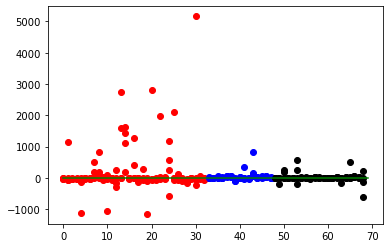

In [ ]:
# colors= ('r','b','k')
for test_data_ind in range(len(sample_names)):
    for model_set in range(3):
        plt.scatter(indices[model_set],lik_ratios_oos[test_data_ind][model_set],c=colors[model_set])
# plt.ylim([-100,100])
plt.plot([0,sum([len(x) for x in indices])],[0,0],'g-')

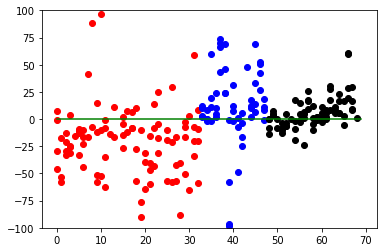

In [ ]:
colors= ('r','b','k')
for test_data_ind in range(len(sample_names)):
    for model_set in range(3):
        plt.scatter(indices[model_set],lik_ratios_oos[test_data_ind][model_set],c=colors[model_set])
plt.ylim([-100,100])
plt.plot([0,sum([len(x) for x in indices])],[0,0],'g-')

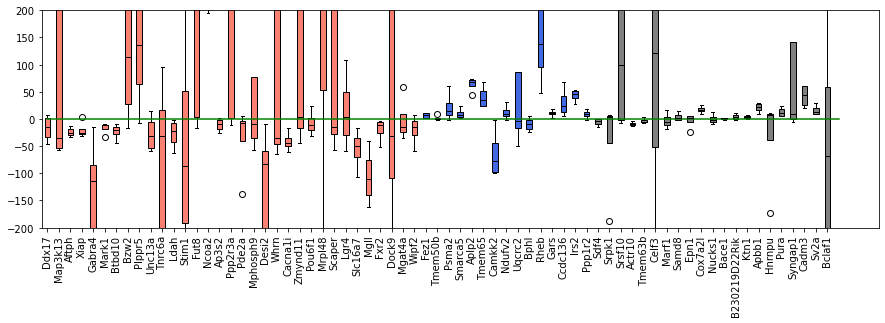

In [ ]:
colors= ('salmon','royalblue','grey')
fig1,ax1 = plt.subplots(1,1,figsize=(15,4))
for model_set in range(3):
    d = np.asarray([lik_ratios_oos[test_data_ind][model_set] for test_data_ind in range(len(sample_looms))])
    bplot = ax1.boxplot(d,positions=indices[model_set],vert=True,patch_artist=True)
    for patch in bplot['boxes']:
        patch.set_facecolor(colors[model_set])
    for median in bplot['medians']:
        median.set_color('k')
#     print(bplot)
#     for test_data_ind in range(len(sample_looms)):
#         plt.scatter(indices[model_set],lik_ratios_oos[test_data_ind][model_set],c=colors[model_set])
ax1.set_ylim([-200,200])
ax1.plot([0,sum([len(x) for x in indices])],[0,0],'g-')
_=ax1.set_xticks(np.concatenate(indices),np.concatenate(gene_names_to_run),rotation=90)

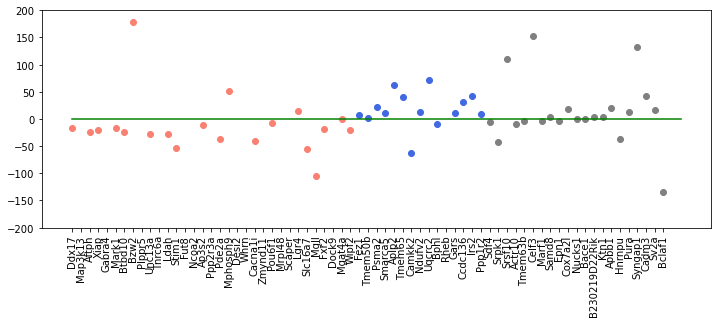

In [ ]:
colors= ('salmon','royalblue','grey')
fig1,ax1 = plt.subplots(1,1,figsize=(12,4))
for model_set in range(3):
    d = np.asarray([lik_ratios_oos[test_data_ind][model_set] for test_data_ind in range(len(sample_looms))])
    ax1.scatter(indices[model_set],d.mean(0),c=colors[model_set])
ax1.set_ylim([-200,200])
ax1.plot([0,1+sum([len(x) for x in indices])],[0,0],'g-')
_=ax1.set_xticks(np.concatenate(indices),np.concatenate(gene_names_to_run),rotation=90)

In [ ]:
with open(subcluster_dir_string+'/logl_fit_results_multis_full_10_15.pickle','wb') as rfs:
    pickle.dump((oss_res,lik_ratios_oos,sample_names,models,gene_names_to_run),rfs)

In [ ]:
t2=time.time()
print('Runtime: {:.1f} minutes.'.format((t2-t1)/60))

Runtime: 2135.0 minutes.


This is the runtime for a 15-gene analysis with maximum of 5 iterations and a single search attempt.
25 min for all genes at those pars.

## SDE goodness of fit

Can also restart here.

In [51]:
subcluster_dir_string = './fits/GVFP_nodate_022_subtypes_1'
input_file = subcluster_dir_string+'/logl_fit_results_multis_full_10_15.pickle' #69 genes, 5 restarts, 10 iter
# input_file = subcluster_dir_string+'/logl_fit_results_multis_full_5_10.pickle' #69 genes, 5 restarts, 10 iter
# input_file = subcluster_dir_string+'/logl_fit_results_multis_full.pickle' #69 genes
# input_file = subcluster_dir_string+'/logl_fit_results_multis.pickle' #15 genes
with open(input_file,'rb') as rfs:
    oss_res,lik_ratios_oos,sample_names,models,gene_names_to_run = pickle.load(rfs)

In [52]:
indices = [np.arange(0,len(gene_names_to_run[0])), \
           np.arange(len(gene_names_to_run[0]), len(gene_names_to_run[0]) + len(gene_names_to_run[1])),\
           np.arange(len(gene_names_to_run[0]) + len(gene_names_to_run[1]), \
                                                len(gene_names_to_run[0]) + len(gene_names_to_run[1]) + len(gene_names_to_run[2]))]

Some of the fits are giving unrealistic and inconsistent likelihood ratios, likely due to suboptimal convergence. In principle, we could fix this by running a lot more trials, or by using Bayes factors, but this is not really practical for exploratory analysis. Instead, we can run another GOF test and throw away fits (and LRs) that are wildly inconsistent with data ($p<10^{-6}$).

In [53]:
gou_pars  = np.array([[np.asarray([z[1] for z in oss_res[x][y]]) for y in models] for x in sample_names],dtype=object)
cir_pars  = np.array([[np.asarray([z[2] for z in oss_res[x][y]]) for y in models] for x in sample_names],dtype=object)

In [54]:
import copy
lik_ratios_checked = np.array(copy.copy([[[z[0] for z in oss_res[x][y]] for y in models] for x in sample_names]),dtype=object)
chisq_thr=5
for test_data_ind in range(len(sample_looms)):
    print(sample_names[test_data_ind])
    with lp.connect(sample_looms[test_data_ind]) as ds:
        U = ds.layers['unspliced'][:]
        S = ds.layers['spliced'][:]
        loom_gene_names = ds.ra['gene_name']
    n_cells = S.shape[1]
    for model_set in range(3):
        print(models[model_set])
        gntr = gene_names_to_run[model_set]
        gene_locations = [np.where(loom_gene_names==x)[0][0] for x in gntr]
#         print(loom_gene_names[gene_locations])
        for gene_count,gene_ind in enumerate(gene_locations):
            lm = np.asarray([U[gene_ind].max()+10,S[gene_ind].max()+10],dtype=int) 
            
            pval = []
            for which_model in ('gou','cir'):
                if which_model == 'gou':
                    par_array = gou_pars
                    lik_fun = get_GOU_2sp
                elif which_model == 'cir':
                    par_array = cir_pars
                    lik_fun = get_CIR_2sp
                    
                pars_gene = par_array[test_data_ind,model_set][gene_count]
                expect_freq = lik_fun(lm,pars_gene) * n_cells

                unique_values,counts = np.unique(np.vstack((U[gene_ind],S[gene_ind])).astype(int),axis=1,return_counts=True) 

                expect_freq = expect_freq[unique_values[0],unique_values[1]]

                expect_freq = np.concatenate((expect_freq,[n_cells-expect_freq.sum()]))
                counts = np.concatenate((counts,[0]))

                filt = (expect_freq>chisq_thr) & (counts>chisq_thr)

                observed = np.concatenate((counts[filt],[counts[~filt].sum()]))
                proposed = np.concatenate((expect_freq[filt],[expect_freq[~filt].sum()])) #this is incredibly severe.
                csq = scipy.stats.mstats.chisquare(observed, proposed, 4) #there are four parameters.
                pval.append(csq.pvalue)
            if (np.asarray(pval)<1e-8).any():
                lik_ratios_checked[test_data_ind,model_set][gene_count] = np.nan

C01


/usr/local/lib/python3.7/dist-packages/h5py/_hl/dataset.py:767: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Bursty
CIR
Extrinsic
B08
Bursty
CIR
Extrinsic
H12
Bursty
CIR
Extrinsic
F08
Bursty
CIR
Extrinsic


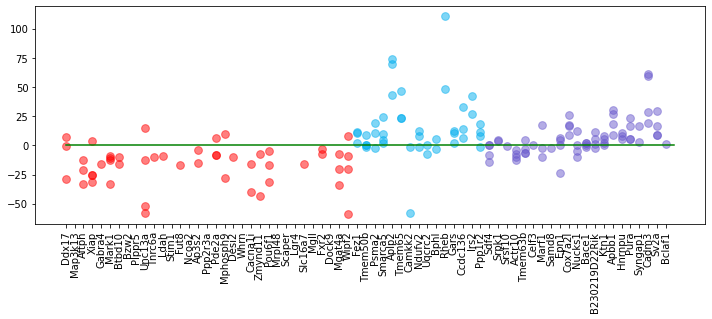

In [55]:
# colors= ('r','b','k')
fig1,ax1 = plt.subplots(1,1,figsize=(12,4))

for test_data_ind in range(len(sample_names)):
    for model_set in range(3):
        plt.scatter(indices[model_set],lik_ratios_checked[test_data_ind][model_set],60,c=colors[model_set],alpha=0.5)
# plt.ylim([-100,100])
plt.plot([0,sum([len(x) for x in indices])],[0,0],'g-')
_=plt.xticks(np.concatenate(indices),np.concatenate(gene_names_to_run),rotation=90)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


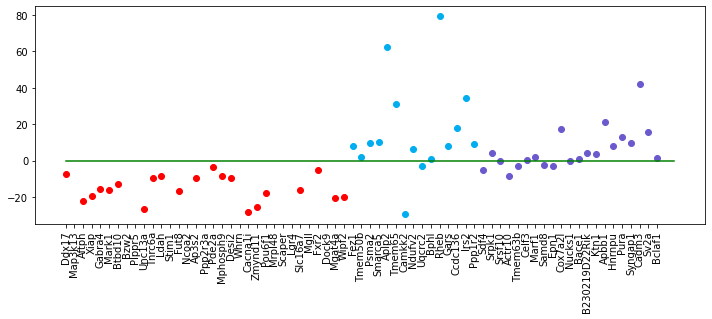

In [78]:
# colors= ('r','b','k')
fig1,ax1 = plt.subplots(1,1,figsize=(12,4))
for model_set in range(n_models):
    d = np.asarray([lik_ratios_checked[test_data_ind][model_set] for test_data_ind in range(n_datasets)])
    ng = len(gene_names_to_run[model_set])
    d_mean = np.empty(ng)
    for gene in range(ng):
        try: 
            d_mean[gene] = np.nanmean(d[:,gene])
        except:
            pass
    ax1.scatter(indices[model_set],d_mean,c=colors[model_set])

ax1.plot([0,1+sum([len(x) for x in indices])],[0,0],'g-')
_=ax1.set_xticks(np.concatenate(indices),np.concatenate(gene_names_to_run),rotation=90)

## Visualization of results

In [79]:
gene_names_to_run

[array(['Ddx17', 'Map3k13', 'Aftph', 'Xiap', 'Gabra4', 'Mark1', 'Btbd10',
        'Bzw2', 'Plppr5', 'Unc13a', 'Tnrc6a', 'Ldah', 'Stim1', 'Fut8',
        'Ncoa2', 'Ap3s2', 'Ppp2r3a', 'Pde2a', 'Mphosph9', 'Desi2', 'Whrn',
        'Cacna1i', 'Zmynd11', 'Pou6f1', 'Mrpl48', 'Scaper', 'Lgr4',
        'Slc16a7', 'Mgll', 'Fxr2', 'Dock9', 'Mgat4a', 'Wipf2'],
       dtype='<U16'),
 array(['Fez1', 'Tmem50b', 'Psma2', 'Smarca5', 'Aplp2', 'Tmem65', 'Camkk2',
        'Ndufv2', 'Uqcrc2', 'Bphl', 'Rheb', 'Gars', 'Ccdc136', 'Irs2',
        'Ppp1r2'], dtype='<U16'),
 array(['Sdf4', 'Srpk1', 'Srsf10', 'Actr10', 'Tmem63b', 'Celf3', 'Marf1',
        'Samd8', 'Epn1', 'Cox7a2l', 'Nucks1', 'Bace1', 'B230219D22Rik',
        'Ktn1', 'Apbb1', 'Hnrnpu', 'Pura', 'Syngap1', 'Cadm3', 'Sv2a',
        'Bclaf1'], dtype='<U16')]

In [80]:
n_cells = np.zeros(4,dtype=int)
for test_data_ind in range(4): 
    with lp.connect(sample_looms[test_data_ind]) as ds:
        n_cells[test_data_ind] = len(ds.ca['barcode'])

/usr/local/lib/python3.7/dist-packages/h5py/_hl/dataset.py:767: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


In [81]:
n_cells

array([4674, 4394, 3335, 4820])

In [82]:

test_data_ind = 3

with lp.connect(sample_looms[test_data_ind]) as ds:
    print(sample_looms[test_data_ind])
    U = ds.layers['unspliced'][:]
    S = ds.layers['spliced'][:]
    loom_gene_names = ds.ra['gene_name']

./loom/allen_F08_glu.loom


In [83]:
colors

('red', (0.0, 0.6823529411764706, 0.9372549019607843), 'slateblue')

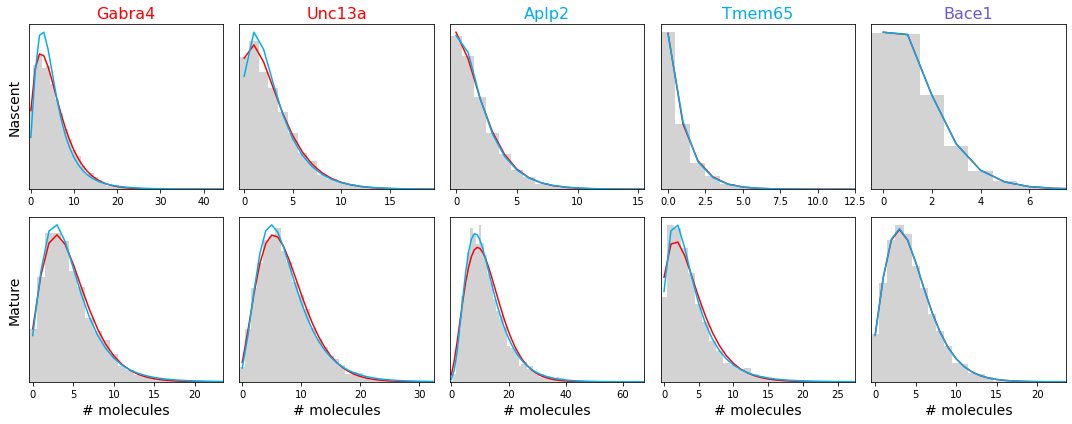

In [84]:
# genes_to_plot = ['Unc13a','Aplp2','Srpk1']
genes_to_plot = ['Gabra4','Unc13a','Aplp2','Tmem65','Bace1']
# 
####
n_genes_to_plot= len(genes_to_plot)

# gou_color='r'
# cir_color='royalblue'

fig1,ax1=plt.subplots(2,n_genes_to_plot,figsize=(3*n_genes_to_plot,6))

gene_locations = np.asarray([np.where(loom_gene_names==x)[0][0] for x in genes_to_plot])

for k,gene_ind in enumerate(gene_locations):
    ax1[0,k].set_title(loom_gene_names[gene_ind],fontsize=16,color=colors[k//2])
    gene_name = genes_to_plot[k]
    model_set = np.where([gene_name in x for x in gene_names_to_run])[0][0]
    location_in_model_set = np.where(gene_name == gene_names_to_run[model_set])[0][0]
    
    mx = np.asarray([U[gene_ind].max()+10,S[gene_ind].max()+10],dtype=int)

    bins = np.arange(mx[0]-8)-0.5
    ax1[0,k].hist(U[gene_ind],bins,color='lightgray',density=True)
    ax1[0,k].set_xlim([-0.5,bins[-1]])
    
    pars_sde_gou = oss_res[sample_names[test_data_ind]][models[model_set]][location_in_model_set][1]
    pars_sde_cir = oss_res[sample_names[test_data_ind]][models[model_set]][location_in_model_set][2]

    y = get_GOU_2sp([mx[0],1],pars_sde_gou)
    ax1[0,k].plot(y,'-',color=gou_color,label='GOU')
    y = get_CIR_2sp([mx[0],1],pars_sde_cir)
    ax1[0,k].plot(y,'-',color=cir_color,label='CIR')

    bins = np.arange(mx[1]-8)-0.5
    ax1[1,k].hist(S[gene_ind],bins,color='lightgray',density=True)
    ax1[1,k].set_xlim([-0.5,bins[-1]])

#     ax1[0,k].set_yscale('log')
#     ax1[1,k].set_yscale('log')
    
    y = get_GOU_2sp([1,mx[1]],pars_sde_gou).squeeze()
    ax1[1,k].plot(y,'-',color=gou_color)
    y = get_CIR_2sp([1,mx[1]],pars_sde_cir).squeeze()
    ax1[1,k].plot(y,'-',color=cir_color)
    
    ax1[0,k].set_yticks([])
    ax1[1,k].set_yticks([])
    if k==0:
        ax1[0,k].set_ylabel('Nascent',fontsize=14)
        ax1[1,k].set_ylabel('Mature',fontsize=14)
    ax1[1,k].set_xlabel('# molecules',fontsize=14)
fig1.tight_layout()


plt.savefig('fig/good_fits.png',dpi=450)
plt.savefig('fig/good_fits.svg')
plt.savefig('fig/good_fits.pdf')

In [85]:
# # genes_to_plot = ['Unc13a','Aplp2','Srpk1']
# genes_to_plot = ['Gabra4','Tmem65','Bace1']
# # 
# ####
# n_genes_to_plot= len(genes_to_plot)

# # gou_color='r'
# # cir_color='royalblue'

# fig1,ax1=plt.subplots(2,n_genes_to_plot,figsize=(4*n_genes_to_plot,6))

# gene_locations = np.asarray([np.where(loom_gene_names==x)[0][0] for x in genes_to_plot])

# for k,gene_ind in enumerate(gene_locations):
#     ax1[0,k].set_title(loom_gene_names[gene_ind],fontsize=16,color=colors[k])
#     gene_name = genes_to_plot[k]
#     model_set = np.where([gene_name in x for x in gene_names_to_run])[0][0]
#     location_in_model_set = np.where(gene_name == gene_names_to_run[model_set])[0][0]
    
#     mx = np.asarray([U[gene_ind].max()+10,S[gene_ind].max()+10],dtype=int)

#     bins = np.arange(mx[0]-8)-0.5
#     ax1[0,k].hist(U[gene_ind],bins,color='lightgray',density=True)
#     ax1[0,k].set_xlim([-0.5,bins[-1]])
    
#     pars_sde_gou = oss_res[sample_names[test_data_ind]][models[model_set]][location_in_model_set][1]
#     pars_sde_cir = oss_res[sample_names[test_data_ind]][models[model_set]][location_in_model_set][2]

#     y = get_GOU_2sp([mx[0],1],pars_sde_gou)
#     ax1[0,k].plot(y,'-',color=gou_color,label='GOU')
#     y = get_CIR_2sp([mx[0],1],pars_sde_cir)
#     ax1[0,k].plot(y,'-',color=cir_color,label='CIR')

#     bins = np.arange(mx[1]-8)-0.5
#     ax1[1,k].hist(S[gene_ind],bins,color='lightgray',density=True)
#     ax1[1,k].set_xlim([-0.5,bins[-1]])

# #     ax1[0,k].set_yscale('log')
# #     ax1[1,k].set_yscale('log')
    
#     y = get_GOU_2sp([1,mx[1]],pars_sde_gou).squeeze()
#     ax1[1,k].plot(y,'-',color=gou_color)
#     y = get_CIR_2sp([1,mx[1]],pars_sde_cir).squeeze()
#     ax1[1,k].plot(y,'-',color=cir_color)
    
#     ax1[0,k].set_yticks([])
#     ax1[1,k].set_yticks([])
#     if k==0:
#         ax1[0,k].set_ylabel('Nascent',fontsize=14)
#         ax1[1,k].set_ylabel('Mature',fontsize=14)
#     ax1[1,k].set_xlabel('# molecules',fontsize=14)
# fig1.tight_layout()


# plt.savefig('fig/good_fits_subset.png',dpi=450)
# plt.savefig('fig/good_fits_subset.svg')
# plt.savefig('fig/good_fits_subset.pdf')

In [86]:
genes_to_plot_split = [['Gabra4', 'Unc13a'],['Aplp2', 'Tmem65'],['Bace1']]

In [87]:
genes_to_plot_split[model_set]

['Bace1']

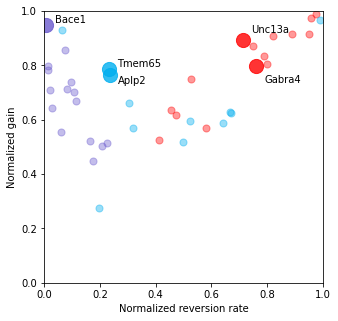

In [88]:
fig1,ax1=plt.subplots(1,1,figsize=(5,5))
markeralpha=0.4

test_data_ind = 3
offsets = [[-0.05, 0.04],[-0.02,0.02],[0.02]]
for model_set in range(3):
    location_in_model_set = [np.where(x== gene_names_to_run[model_set])[0][0] for x in genes_to_plot_split[model_set] ]

    pars_subset = gou_pars[test_data_ind][model_set][~np.isnan(lik_ratios_checked[test_data_ind][model_set])] #beta,gamma,a,kappa,theta
    x = pars_subset[:,3]/(pars_subset[:,3] + pars_subset[:,0] + pars_subset[:,1])
    y = pars_subset[:,4]/(pars_subset[:,4] + pars_subset[:,2]) 
    
    
    gf = np.zeros(len(x),dtype=bool)
    gf[location_in_model_set] = True
    ax1.scatter(x[~gf],y[~gf],50,colors[model_set],alpha=markeralpha)
    ax1.scatter(x[gf],y[gf],200,colors[model_set],alpha=0.8)
    for k,g__ in enumerate(location_in_model_set):
        ax1.text(x[gf][k]+0.03,y[gf][k]+offsets[model_set][k],genes_to_plot_split[model_set][k],\
                verticalalignment='center')

ax1.set_xlim([0,1])
ax1.set_ylim([0,1])
ax1.set_xlabel('Normalized reversion rate')
ax1.set_ylabel('Normalized gain')

plt.savefig('fig/empirical_parameter_regimes.png',dpi=450)
plt.savefig('fig/empirical_parameter_regimes.svg')
plt.savefig('fig/empirical_parameter_regimes.pdf')

In [89]:

test_data_ind = 0

with lp.connect(sample_looms[test_data_ind]) as ds:
    print(sample_looms[test_data_ind])
    U = ds.layers['unspliced'][:]
    S = ds.layers['spliced'][:]
    loom_gene_names = ds.ra['gene_name']

/usr/local/lib/python3.7/dist-packages/h5py/_hl/dataset.py:767: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


./loom/allen_C01_glu.loom


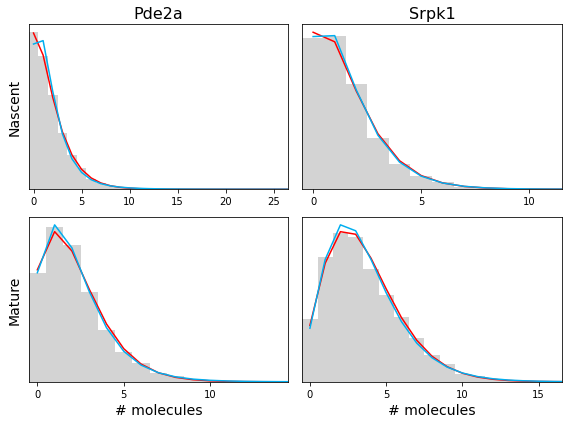

In [90]:
genes_to_plot = ['Pde2a', 'Srpk1']

####
n_genes_to_plot= len(genes_to_plot)

# gou_color='r'
# cir_color='royalblue'

fig1,ax1=plt.subplots(2,n_genes_to_plot,figsize=(4*n_genes_to_plot,6))

gene_locations = np.asarray([np.where(loom_gene_names==x)[0][0] for x in genes_to_plot])

for k,gene_ind in enumerate(gene_locations):
    gene_name = genes_to_plot[k]
    model_set = np.where([gene_name in x for x in gene_names_to_run])[0][0]
    location_in_model_set = np.where(gene_name == gene_names_to_run[model_set])[0][0]
    
    mx = np.asarray([U[gene_ind].max()+10,S[gene_ind].max()+10],dtype=int)

    bins = np.arange(mx[0]-8)-0.5
    ax1[0,k].hist(U[gene_ind],bins,color='lightgray',density=True)
    ax1[0,k].set_title(loom_gene_names[gene_ind],fontsize=16)
    ax1[0,k].set_xlim([-0.5,bins[-1]])
    ax1[0,k].set_xticks(np.arange(0,bins[-1],5))
    
    pars_sde_gou = oss_res[sample_names[test_data_ind]][models[model_set]][location_in_model_set][1]
    pars_sde_cir = oss_res[sample_names[test_data_ind]][models[model_set]][location_in_model_set][2]

    y = get_GOU_2sp([mx[0],1],pars_sde_gou)
    ax1[0,k].plot(y,'-',color=gou_color,label='GOU')
    y = get_CIR_2sp([mx[0],1],pars_sde_cir)
    ax1[0,k].plot(y,'-',color=cir_color,label='CIR')
#     ax1[0,k].legend()

    bins = np.arange(mx[1]-8)-0.5
    ax1[1,k].hist(S[gene_ind],bins,color='lightgray',density=True)
    ax1[1,k].set_xlim([-0.5,bins[-1]])
    ax1[1,k].set_xticks(np.arange(0,bins[-1],5))

#     ax1[0,k].set_yscale('log')
#     ax1[1,k].set_yscale('log')
    
    y = get_GOU_2sp([1,mx[1]],pars_sde_gou).squeeze()
    ax1[1,k].plot(y,'-',color=gou_color)
    y = get_CIR_2sp([1,mx[1]],pars_sde_cir).squeeze()
    ax1[1,k].plot(y,'-',color=cir_color)
    
    ax1[0,k].set_yticks([])
    ax1[1,k].set_yticks([])
    if k==0:
        ax1[0,k].set_ylabel('Nascent',fontsize=14)
        ax1[1,k].set_ylabel('Mature',fontsize=14)
    ax1[1,k].set_xlabel('# molecules',fontsize=14)
fig1.tight_layout()


plt.savefig('fig/questionable_fits.png',dpi=450)
plt.savefig('fig/questionable_fits.svg')
plt.savefig('fig/questionable_fits.pdf')

## Whole-dataset visualizations

In [91]:
gene_names_to_run

[array(['Ddx17', 'Map3k13', 'Aftph', 'Xiap', 'Gabra4', 'Mark1', 'Btbd10',
        'Bzw2', 'Plppr5', 'Unc13a', 'Tnrc6a', 'Ldah', 'Stim1', 'Fut8',
        'Ncoa2', 'Ap3s2', 'Ppp2r3a', 'Pde2a', 'Mphosph9', 'Desi2', 'Whrn',
        'Cacna1i', 'Zmynd11', 'Pou6f1', 'Mrpl48', 'Scaper', 'Lgr4',
        'Slc16a7', 'Mgll', 'Fxr2', 'Dock9', 'Mgat4a', 'Wipf2'],
       dtype='<U16'),
 array(['Fez1', 'Tmem50b', 'Psma2', 'Smarca5', 'Aplp2', 'Tmem65', 'Camkk2',
        'Ndufv2', 'Uqcrc2', 'Bphl', 'Rheb', 'Gars', 'Ccdc136', 'Irs2',
        'Ppp1r2'], dtype='<U16'),
 array(['Sdf4', 'Srpk1', 'Srsf10', 'Actr10', 'Tmem63b', 'Celf3', 'Marf1',
        'Samd8', 'Epn1', 'Cox7a2l', 'Nucks1', 'Bace1', 'B230219D22Rik',
        'Ktn1', 'Apbb1', 'Hnrnpu', 'Pura', 'Syngap1', 'Cadm3', 'Sv2a',
        'Bclaf1'], dtype='<U16')]

In [92]:
lik_ratios_checked[0,0][2]

nan

/usr/local/lib/python3.7/dist-packages/h5py/_hl/dataset.py:767: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


./loom/allen_F08_glu.loom


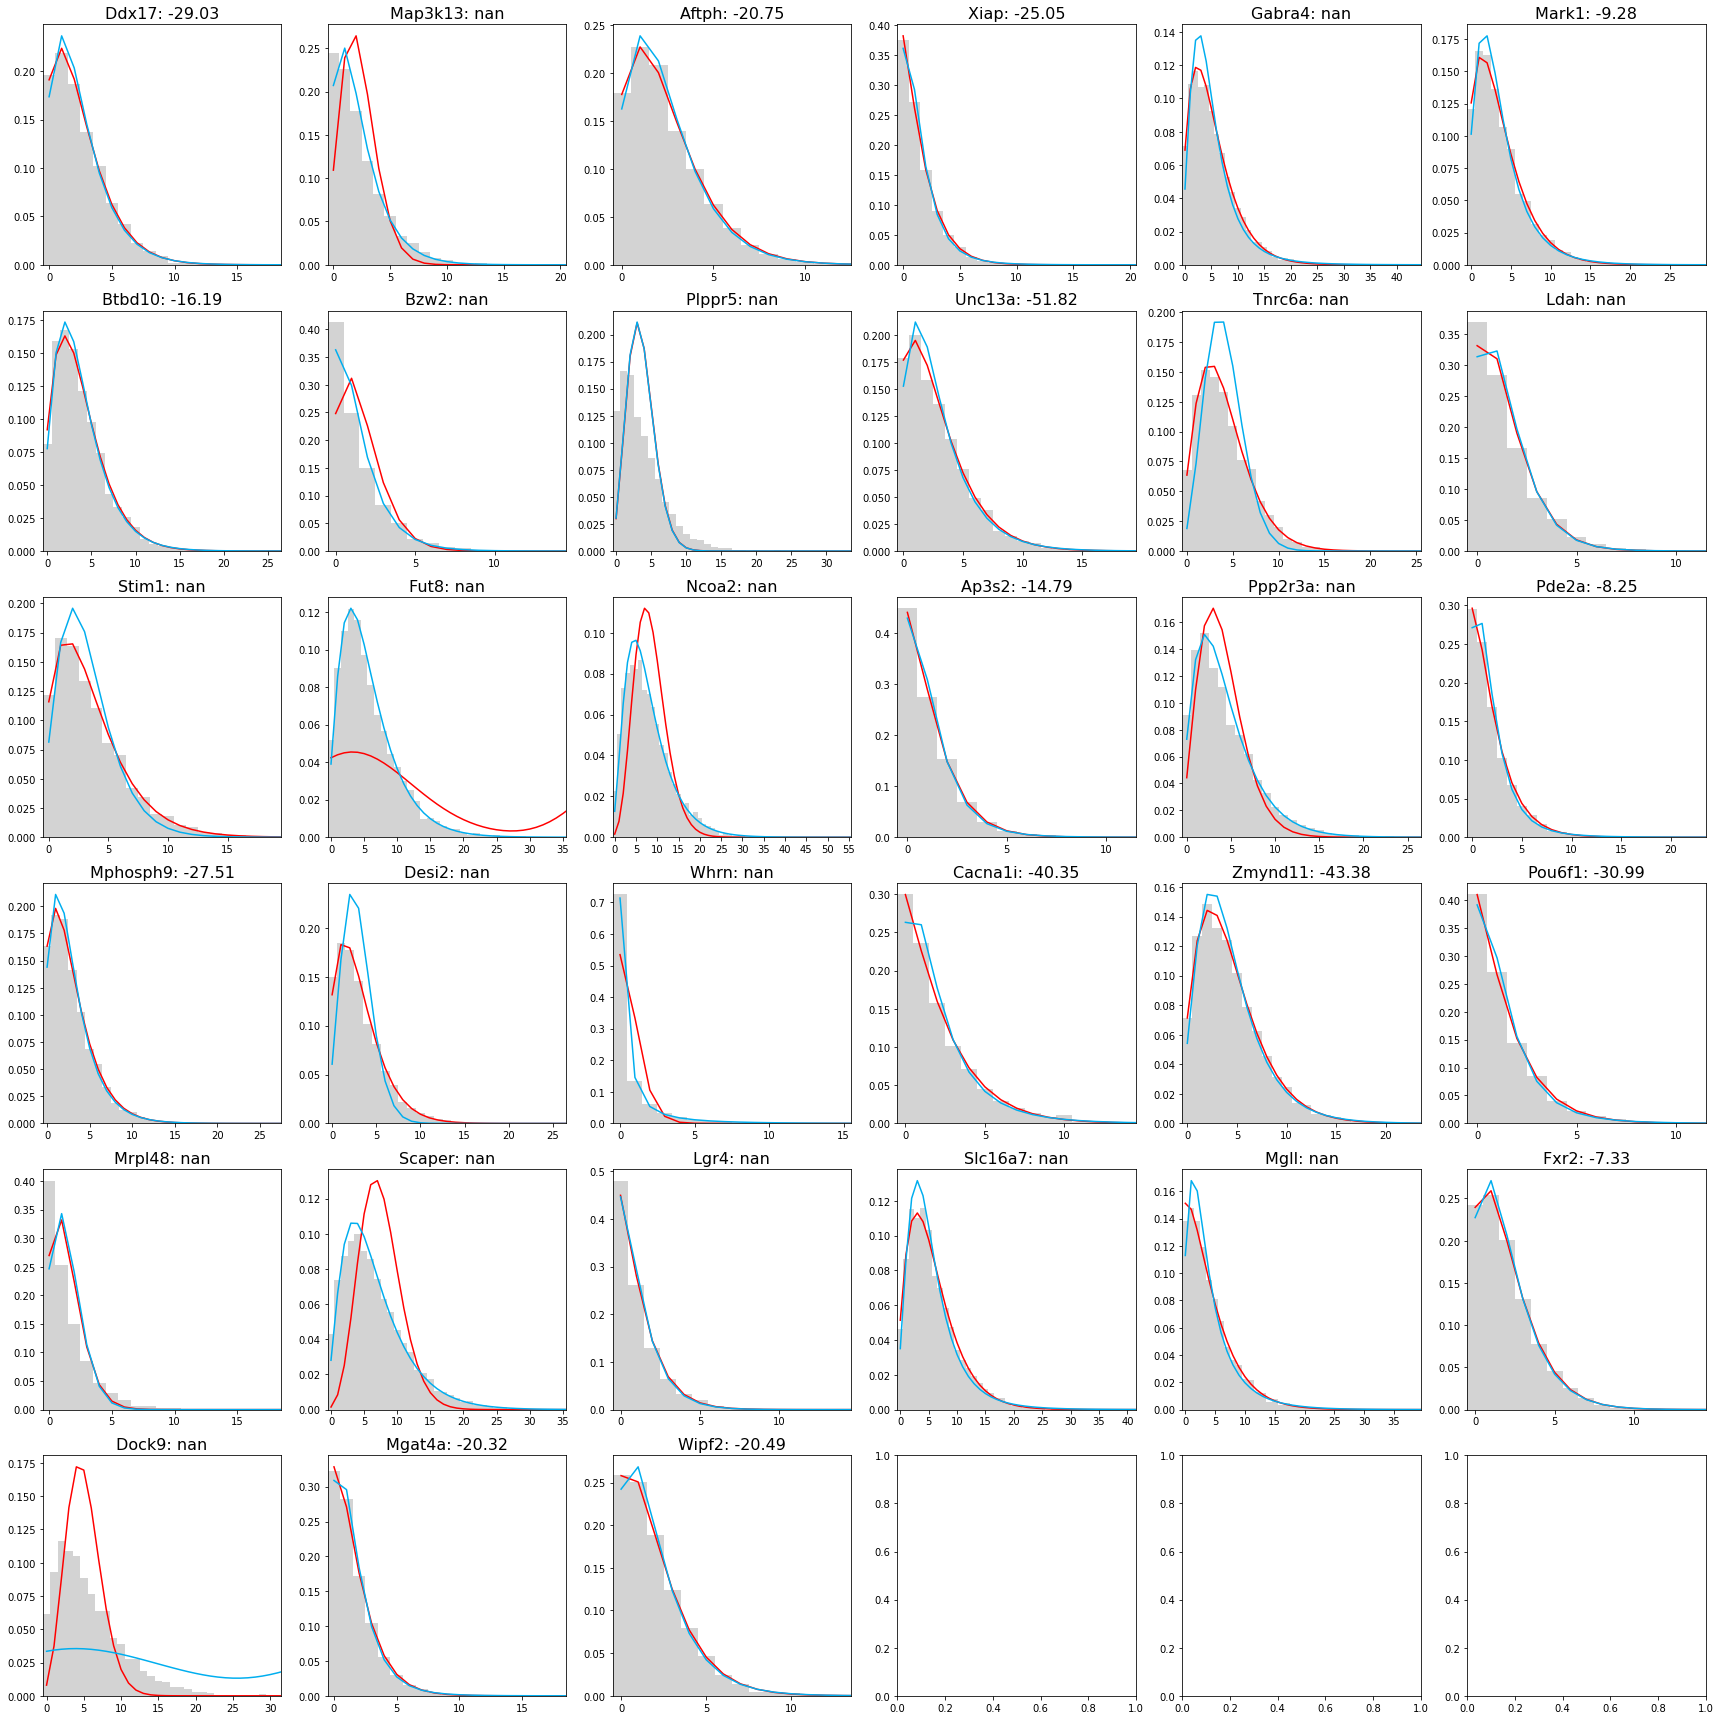

In [93]:
model_ind_to_plot = 0 #which gene set? 0 = gou-like, 1 = cir-like, 2 = extrinsic-like
species = 'unspliced'
test_data_ind = 3
######################

with lp.connect(sample_looms[test_data_ind]) as ds:
    print(sample_looms[test_data_ind])
    count_data = ds.layers[species][:]
    loom_gene_names = ds.ra['gene_name']


genes_to_plot = gene_names_to_run[model_ind_to_plot]
n_genes_to_plot= len(genes_to_plot)

subplot_width = 6
subplot_height = n_genes_to_plot//subplot_width
if (n_genes_to_plot%subplot_width)>0:
    subplot_height += 1
fig1,ax1=plt.subplots(subplot_height,subplot_width,figsize=(4*subplot_width,4*subplot_height))

gene_locations = np.asarray([np.where(loom_gene_names==x)[0][0] for x in genes_to_plot])

for k,gene_ind in enumerate(gene_locations):
    axloc = np.unravel_index(k,(subplot_height,subplot_width))
    gene_name = genes_to_plot[k]
    model_set = np.where([gene_name in x for x in gene_names_to_run])[0][0]
    location_in_model_set = np.where(gene_name == gene_names_to_run[model_set])[0][0]
    
    mx_bnd = int(count_data[gene_ind].max()+10)
    if species=='unspliced':
        mx = [mx_bnd,1]
    elif species=='spliced':
        mx = [1,mx_bnd]
#     mx = np.asarray(mx)

    bins = np.arange(mx_bnd-8)-0.5
    ax1[axloc].hist(count_data[gene_ind],bins,color='lightgray',density=True)
    ax1[axloc].set_xlim([-0.5,bins[-1]])
    ax1[axloc].set_xticks(np.arange(0,bins[-1],5))
    
    pars_sde_gou = oss_res[sample_names[test_data_ind]][models[model_set]][location_in_model_set][1]
    pars_sde_cir = oss_res[sample_names[test_data_ind]][models[model_set]][location_in_model_set][2]

    y = get_GOU_2sp(mx,pars_sde_gou)
    ax1[axloc].plot(y,'-',color=gou_color,label='GOU')
    y = get_CIR_2sp(mx,pars_sde_cir)
    ax1[axloc].plot(y,'-',color=cir_color,label='CIR')
    ax1[axloc].set_title(loom_gene_names[gene_ind] + ': {:.2f}'.format(lik_ratios_checked[test_data_ind,model_ind_to_plot][k]),fontsize=16)

fig1.tight_layout()


In [94]:
# lik_ratios

## Bayes factors

In [95]:
# BF_genes= ['Pou6f1','Gabra4', 'Tmem65','Aplp2', 'Bace1','Srpk1']
BF_genes= ['Pou6f1','Gabra4','Aftph','Mark1',\
           'Tmem65','Aplp2','Psma2', 'Ppp1r2',\
           'Bace1','Srpk1', 'Nucks1', 'Ktn1'] 

BF = np.load('loom/smc_results/four/bfs.npy')

In [96]:
indices_all = np.concatenate(indices)
n_genes = len(indices_all)
lik_ratios = np.zeros((n_datasets,n_genes))
for test_data_ind in range(n_datasets):
    for model_ind in range(n_models):
        lik_ratios[test_data_ind,indices[model_ind]] = lik_ratios_checked[test_data_ind,model_ind]
genes_all = np.concatenate(gene_names_to_run)
gene_colors = sum([[colors[x]]*len(indices[x]) for x in range(n_models)],[])

gf = ~(np.isnan(lik_ratios).all(0))
lik_ratios = lik_ratios[:,gf]
genes_all = genes_all[gf]
gene_colors = [x for k,x in enumerate(gene_colors) if gf[k]]
n_genes = gf.sum()
indices_all = indices_all[gf]
plot_indices = np.arange(n_genes)

In [97]:
n_genes

57

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1026: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


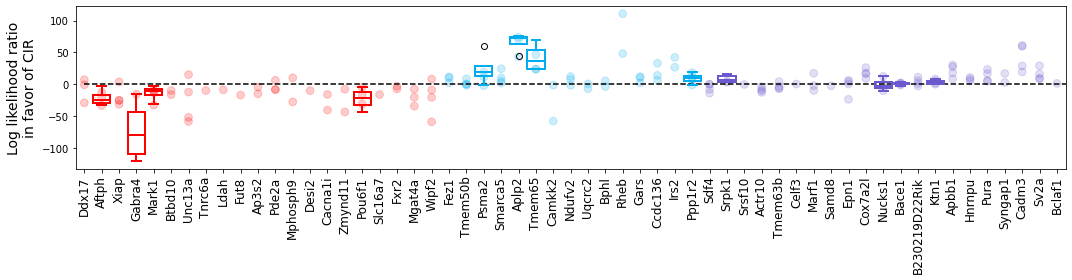

In [98]:
markeralpha=0.2
fig1,ax1 = plt.subplots(1,1,figsize=(15,4))

ax1.plot([0,n_genes],[0,0],'k--')

for test_data_ind in range(len(sample_names)):
    ax1.scatter(plot_indices,lik_ratios[test_data_ind],\
                60,c=gene_colors,alpha=markeralpha)

lw=2

for k,BF_gene in enumerate(BF_genes):
    BF_gene_ind = np.where(genes_all==BF_gene)[0][0]
    bp_dict = {'linewidth':lw,'color':gene_colors[BF_gene_ind]}
    bplot = ax1.boxplot(BF[:,k], \
                        positions = [BF_gene_ind],widths=1,patch_artist=True,\
                        boxprops = {'linewidth':lw,'color':gene_colors[BF_gene_ind],'facecolor':'None'},
                        capprops = bp_dict,
                        medianprops = bp_dict,
                        whiskerprops = bp_dict,
                        flierprops = bp_dict)

ax1.set_ylabel('Log likelihood ratio\nin favor of CIR',fontsize=14)
_=ax1.set_xticks(plot_indices,genes_all,rotation=90,fontsize=12)
ax1.set_xlim([-0.5,n_genes-0.5])

fig1.tight_layout()
plt.savefig('fig/BFs.png',dpi=450)
plt.savefig('fig/BFs.svg')
plt.savefig('fig/BFs.pdf')

In [99]:
len(plot_indices)

57